## Install essential libraries

In [2]:
#pip install gseapy
#pip install lifelines

import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import miner_py3 as miner

## Define local directories

In [41]:
#local path to miner download
miner_directory = os.path.join(os.path.expanduser('~'),
                               'Desktop','miner3-master','miner')
#local path to miner network directory   
network_directory = os.path.join(miner_directory,'myeloma_network')

# create name for results folder where output files will be saved
resultsFolder = "supplemental_results"

# create results directory
resultsDirectory = os.path.join(miner_directory,resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load primary data

In [42]:
# Load expression Data
expressionFile = os.path.join(miner_directory,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0) #use if data is already normalized
expressionData, conversionTable = miner.preprocess(expressionFile) #not for counts format

# Load mutations
common_mutations = pd.read_csv(os.path.join(miner_directory,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(miner_directory,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(miner_directory,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(network_directory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(network_directory,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(network_directory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(network_directory,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(network_directory,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(network_directory,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(network_directory,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(network_directory,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(miner_directory,"data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(network_directory,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(network_directory,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1
    
# load primary survival data (i.e., corresponding to expression data training set)
survivalMMRF = pd.read_csv(os.path.join(miner_directory,"data","survival","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
kmDfMMRF = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
guanSurvivalDfMMRF= miner.guanRank(kmSurvival=kmDfMMRF)

print('Data loading complete')

completed identifier conversion.
16216 genes were converted.
Data loading complete


## Define baseline and relapse patients

In [43]:
# Identify baseline and relapse patients
baseline_patients = [name for name in expressionData.columns if name.split("_")[2]=='1']
relapse_patients = [name for name in expressionData.columns if name.split("_")[2]=='2']
all_relapse_patients = [name for name in expressionData.columns if name.split("_")[2]!='1']
print('Baseline:',len(baseline_patients),'First relapse:',len(relapse_patients),'\nAny relapse:',len(all_relapse_patients))

Baseline: 779 First relapse: 56 
Any relapse: 102


## Load pathways enrichment matrix

In [13]:
#Read normalized enrichment scores for MSigDb pathways databases of each expression profile
pathways_mmrf = pd.read_csv(os.path.join(input_path,"data","expression","MMRF_Pathways.csv"),index_col=0,header=0)

## Compare pathway enrichment scores at baseline and relapse

In [23]:
# Define two phenotypes for comparison
phenotype1 = baseline_patients
phenotype2 = relapse_patients

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_relapse = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_relapse.tail(10)

,Statistic,p-value
REACTOME_NEUTROPHIL_DEGRANULATION,-5.202165,1.969800e-07
REACTOME_TCR_SIGNALING,-5.271573,1.352592e-07
KEGG_GLUTATHIONE_METABOLISM,-5.311153,1.089337e-07
REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES,-5.323199,1.019580e-07
REACTOME_TRANSLOCATION_OF_ZAP_70_TO_IMMUNOLOGICAL_SYNAPSE,-5.429893,5.638797e-08
KEGG_PENTOSE_PHOSPHATE_PATHWAY,-5.432761,5.548879e-08
NABA_ECM_AFFILIATED,-5.535439,3.104501e-08
REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION,-5.577887,2.434581e-08
REACTOME_IMMUNOREGULATORY_INTERACTIONS_BETWEEN_A_LYMPHOID_AND_A_NON_LYMPHOID_CELL,-5.596816,2.183239e-08
REACTOME_PHOSPHORYLATION_OF_CD3_AND_TCR_ZETA_CHAINS,-5.696053,1.226131e-08


## Compare boxplots of selected pathways

<ipython-input-24-277508b18b1a>:8: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title(pthwy+'\nWilcoxon p-value: {:.3e}'.format(wrs[1]),FontSize=14)


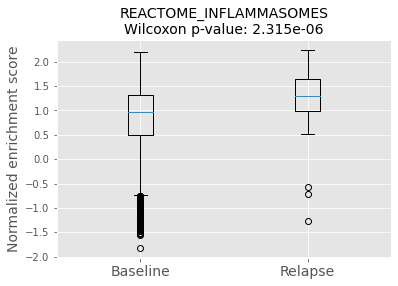

In [24]:
# Select pathway for visualization
pthwy = "REACTOME_INFLAMMASOMES"
plt.boxplot([pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2]])

wrs = stats.ranksums(pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2])
plt.title(pthwy+'\nWilcoxon p-value: {:.3e}'.format(wrs[1]),FontSize=14)
plt.ylabel('Normalized enrichment score',fontsize=14)
plt.xticks([1, 2], ["Baseline","Relapse"],fontsize=14)
plt.show()

## Identify high- and low-risk subsets

In [25]:
# Training and test set risk cut-offs
train_cut_high = 0.20
train_cut_low = 0.50
test_cut = 0.20

# Define low- and high-risk patients
high_risk_MMRF = guanSurvivalDfMMRF.index[0:round(guanSurvivalDfMMRF.shape[0]*train_cut_high)]
low_risk_MMRF = guanSurvivalDfMMRF.index[round(guanSurvivalDfMMRF.shape[0]*train_cut_low):]

## Compare pathway enrichment scores of high- and low-risk

In [26]:
# Analyze low-risk and high-risk phenotypes
phenotype1 = high_risk_MMRF
phenotype2 = low_risk_MMRF

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_risk = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_risk.head(10)

,Statistic,p-value
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX,7.339830,2.138659e-13
BIOCARTA_MCM_PATHWAY,7.336156,2.198153e-13
REACTOME_CELL_CYCLE_MITOTIC,7.278608,3.372816e-13
REACTOME_DNA_STRAND_ELONGATION,7.170246,7.486289e-13
KEGG_DNA_REPLICATION,7.091271,1.328860e-12
REACTOME_CHROMOSOME_MAINTENANCE,7.085761,1.382823e-12
KEGG_CELL_CYCLE,7.029437,2.073681e-12
REACTOME_CELL_CYCLE_CHECKPOINTS,6.988419,2.780012e-12
REACTOME_MITOTIC_G1_G1_S_PHASES,6.971277,3.140769e-12
REACTOME_G2_M_CHECKPOINTS,6.955972,3.501403e-12


## Subtype-specific risk t(4;14)

In [27]:
# Load mutation information
t414_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)

# Compare low-and high-risk within subtype
subtype = t414_patients
srv = guanSurvivalDfMMRF.loc[miner.intersect(subtype,guanSurvivalDfMMRF.index),:]
srv.sort_values(by="GuanScore",ascending=False,inplace=True)

# Split into low- and high-risk
# Training and test set risk cut-offs
train_cut_high = 0.30
train_cut_low = 0.70

# Define low- and high-risk patients
high_risk_subtype = srv.index[0:round(srv.shape[0]*train_cut_high)]
low_risk_subtype = srv.index[round(srv.shape[0]*train_cut_low):]

# Analyze low-risk and high-risk phenotypes
phenotype1 = high_risk_subtype
phenotype2 = low_risk_subtype

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_t414 = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_t414.head(10)

,Statistic,p-value
REACTOME_COOPERATION_OF_PREFOLDIN_AND_TRIC_CCT_IN_ACTIN_AND_TUBULIN_FOLDING,4.825607,0.000001
REACTOME_PREFOLDIN_MEDIATED_TRANSFER_OF_SUBSTRATE_TO_CCT_TRIC,4.798110,0.000002
REACTOME_FORMATION_OF_TUBULIN_FOLDING_INTERMEDIATES_BY_CCT_TRIC,4.756866,0.000002
REACTOME_KINESINS,4.633132,0.000004
PID_MYC_ACTIV_PATHWAY,4.399413,0.000011
REACTOME_GAP_JUNCTION_ASSEMBLY,4.399413,0.000011
PID_FOXM1_PATHWAY,4.330673,0.000015
REACTOME_POST_CHAPERONIN_TUBULIN_FOLDING_PATHWAY,4.330673,0.000015
KEGG_PURINE_METABOLISM,4.248184,0.000022
KEGG_PYRIMIDINE_METABOLISM,4.193191,0.000028


## Subtype-specific risk Amp 1q

In [28]:
# Load mutation information
amp1q_patients = miner.getMutations("amp1q",cytogenetics)

# Compare low-and high-risk within subtype
subtype = amp1q_patients
srv = guanSurvivalDfMMRF.loc[miner.intersect(subtype,guanSurvivalDfMMRF.index),:]
srv.sort_values(by="GuanScore",ascending=False,inplace=True)

# Split into low- and high-risk
# Training and test set risk cut-offs
train_cut_high = 0.30
train_cut_low = 0.70

# Define low- and high-risk patients
high_risk_subtype = srv.index[0:round(srv.shape[0]*train_cut_high)]
low_risk_subtype = srv.index[round(srv.shape[0]*train_cut_low):]

# Analyze low-risk and high-risk phenotypes
phenotype1 = high_risk_subtype
phenotype2 = low_risk_subtype

# Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
wilcoxon_amp1q = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)

# View top results
wilcoxon_amp1q.head(10)

,Statistic,p-value
REACTOME_MEIOSIS,5.363673,8.154664e-08
REACTOME_CHROMOSOME_MAINTENANCE,5.220300,1.786335e-07
REACTOME_RECRUITMENT_OF_NUMA_TO_MITOTIC_CENTROSOMES,5.194698,2.050527e-07
REACTOME_CELL_CYCLE_MITOTIC,5.179336,2.226766e-07
REACTOME_TELOMERE_MAINTENANCE,5.163975,2.417599e-07
REACTOME_RHO_GTPASES_ACTIVATE_FORMINS,5.158855,2.484652e-07
REACTOME_RHO_GTPASE_EFFECTORS,5.133252,2.847777e-07
REACTOME_CENTROSOME_MATURATION,5.107650,3.261900e-07
REACTOME_REPRODUCTION,5.087168,3.634493e-07
REACTOME_MITOTIC_PROPHASE,5.082048,3.733874e-07


## State-specific pathways

In [46]:
state_pathways_dfs = []
for i in range(len(states)):
    # Define two phenotypes for comparison
    phenotype1 = states[i]
    phenotype2 = miner.setdiff(pathways_mmrf.columns,phenotype1)

    # Perform wilcoxon rank-sum test for all pathway nes values across phenotypes
    wilcoxon_state = miner.wilcox_df(pathways_mmrf,phenotype1,phenotype2)
    
    # Append enrichment information to list
    state_pathways_dfs.append(wilcoxon_state)

    print('completed iteration {:d}'.format(i+1))



completed iteration 1
completed iteration 2
completed iteration 3
completed iteration 4
completed iteration 5
completed iteration 6
completed iteration 7
completed iteration 8
completed iteration 9
completed iteration 10
completed iteration 11
completed iteration 12
completed iteration 13
completed iteration 14
completed iteration 15
completed iteration 16
completed iteration 17
completed iteration 18
completed iteration 19
completed iteration 20
completed iteration 21
completed iteration 22
completed iteration 23
completed iteration 24
completed iteration 25
completed iteration 26


In [77]:
# Write dfs to files
for i in range(len(states)):
    state_pathways_dfs[i].to_csv(os.path.join(resultsDirectory,("_").join(["state",str(i),"pathways.csv"])))

In [1106]:
# Investigate state-specific results
state_pathways_dfs[14].head(25)

,Statistic,p-value
KEGG_CELL_CYCLE,7.628921,2.367260e-14
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX,7.574429,3.607105e-14
REACTOME_RHO_GTPASES_ACTIVATE_FORMINS,7.565483,3.864274e-14
REACTOME_EXTENSION_OF_TELOMERES,7.563856,3.912932e-14
REACTOME_COOPERATION_OF_PREFOLDIN_AND_TRIC_CCT_IN_ACTIN_AND_TUBULIN_FOLDING,7.553283,4.244221e-14
KEGG_PYRIMIDINE_METABOLISM,7.534576,4.899223e-14
REACTOME_SUMOYLATION_OF_DNA_REPLICATION_PROTEINS,7.511804,5.831825e-14
REACTOME_CELL_CYCLE_MITOTIC,7.497977,6.481019e-14
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,7.493097,6.726702e-14
PID_AURORA_B_PATHWAY,7.475204,7.708402e-14


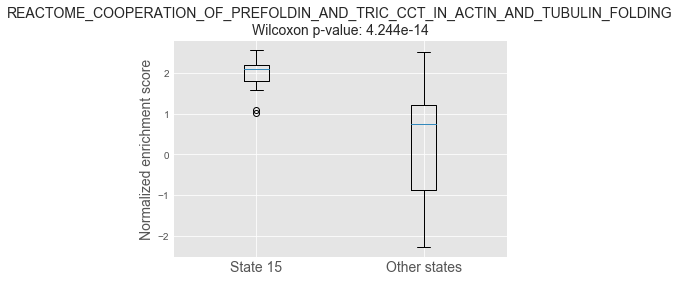

In [1110]:
# Select pathway for visualization
pthwy = "REACTOME_COOPERATION_OF_PREFOLDIN_AND_TRIC_CCT_IN_ACTIN_AND_TUBULIN_FOLDING"

#Define phenotypes
state_ix = 14
phenotype1 = states[state_ix]
phenotype2 = miner.setdiff(pathways_mmrf.columns,phenotype1)

#Calculate significance of differential expression
wrs = stats.ranksums(pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2])

#Generate boxplot
plt.boxplot([pathways_mmrf.loc[pthwy,phenotype1],
             pathways_mmrf.loc[pthwy,phenotype2]])
plt.title(pthwy+'\nWilcoxon p-value: {:.3e}'.format(wrs[1]),FontSize=14)
plt.ylabel('Normalized enrichment score',fontsize=14)
_=plt.xticks([1, 2], ["State "+str(state_ix+1),"Other states"],fontsize=14)

## Compare program activities across states

In [30]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

In [31]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedProgramsMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

done!
done!


In [32]:
dfr_pr = overExpressedProgramsMatrix_pr - underExpressedProgramsMatrix_pr

In [33]:
# Get eigengenes for all modules
eigengenes_pr = miner.getEigengenes(pr_genes,expressionData,regulon_dict=None,saveFolder=None)
eigenScale_pr = np.percentile(expressionData,95)/np.percentile(eigengenes_pr,95)
eigengenes_pr = eigenScale_pr*eigengenes_pr
eigengenes_pr.index = np.array(eigengenes_pr.index).astype(int)
#write eigengenes to .csv
eigengenes_pr.to_csv(os.path.join(resultsDirectory,"eigengenes_pr.csv"))


Text(0.5, 1.0, 'Program eigengenes')

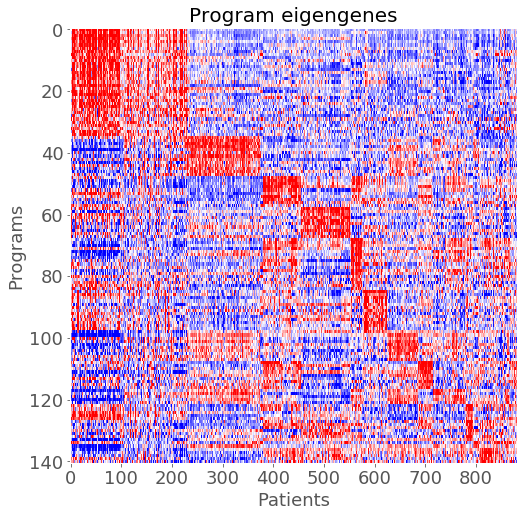

In [91]:
#Plot program eigengenes
plt.figure(figsize=(8,8))
plt.imshow(eigengenes_pr.loc[:,np.hstack(states)],cmap="bwr",aspect="auto",vmin=-1.5,vmax=1.5)
plt.grid(False)
plt.ylabel("Programs",fontsize=18)
plt.xlabel("Patients",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program eigengenes",fontsize=20)

Text(0.5, 1.0, 'Program activity')

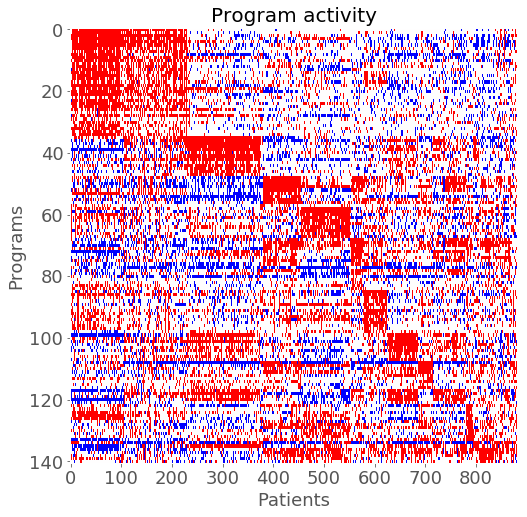

In [92]:
#Plot program activity
plt.figure(figsize=(8,8))
plt.imshow(dfr_pr.loc[:,np.hstack(states)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.ylabel("Programs",fontsize=18)
plt.xlabel("Patients",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program activity",fontsize=20)

In [186]:
program_ix = 68
mean_eigengene = []
mean_activity = []
wilcoxon_eigengene = []
wilcoxon_activity = []
guanrisk_mean = []
for s in range(len(states)):
    phenotype1 = states[s]
    phenotype2 = miner.setdiff(np.hstack(states),phenotype1)
    tmp_activity = np.mean(dfr_pr.loc[program_ix,phenotype1])
    tmp_eigengene = np.mean(eigengenes_pr.loc[program_ix,phenotype1])
    tmp_wilcox_activity = stats.ranksums(dfr_pr.loc[program_ix,phenotype1],dfr_pr.loc[program_ix,phenotype2])
    tmp_wilcox_eigengene = stats.ranksums(eigengenes_pr.loc[program_ix,phenotype1],eigengenes_pr.loc[program_ix,phenotype2])
    tmp_pats = miner.intersect(phenotype1,guanSurvivalDfMMRF.index)
    tmp_guan = 0
    if len(tmp_pats) >= 3:
        tmp_guan = guanSurvivalDfMMRF.loc[tmp_pats,"GuanScore"].mean()
         
    # Append to lists
    mean_eigengene.append(tmp_eigengene)
    mean_activity.append(tmp_activity)
    wilcoxon_eigengene.append(tmp_wilcox_eigengene)
    wilcoxon_activity.append(tmp_wilcox_activity)
    guanrisk_mean.append(tmp_guan)
    

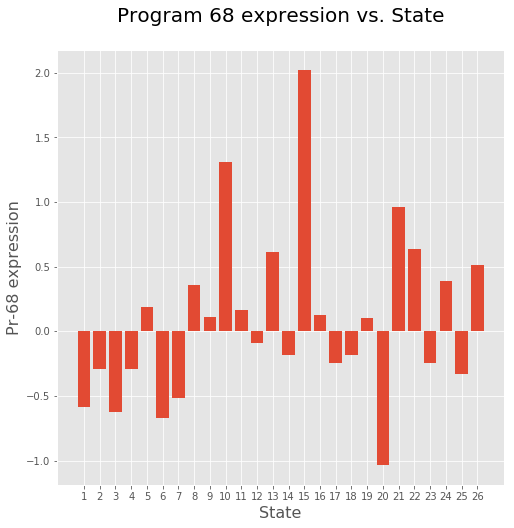

In [187]:
wilcoxon_eigengene_stat = [wilcoxon_eigengene[i][0] for i in range(len(wilcoxon_eigengene))]
plt.figure(figsize=(8,8))
plt.bar(np.arange(len(mean_eigengene)),mean_eigengene)
plt.ylabel("Pr-68 expression",fontsize=16)
plt.xlabel("State",fontsize=16)
_=plt.xticks(np.arange(len(mean_eigengene)),labels=np.arange(1,len(mean_eigengene)+1))
plt.title("Program 68 expression vs. State\n",fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Pr_68_eigengene_vs_state.pdf"),bbox_inches="tight")

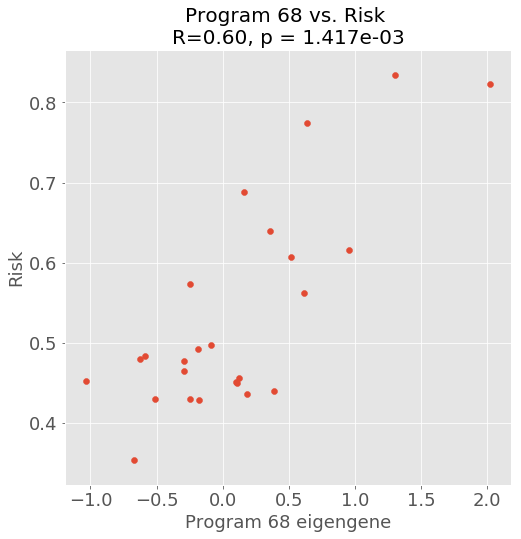

In [188]:
#Program 68 eigengene vs risk
plt.figure(figsize=(8,8))
plt.scatter(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
r,p = stats.spearmanr(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
plt.ylabel("Risk",fontsize=18)
plt.xlabel("Program 68 eigengene",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program 68 vs. Risk \nR={:.2f}, p = {:.3e}".format(r,p),fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Pr_68_eigengene_vs_risk.pdf"),bbox_inches="tight")

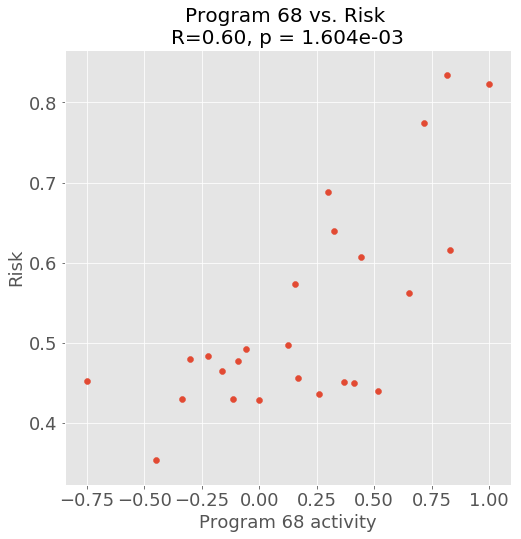

In [189]:
#Program 68 activity vs risk
plt.figure(figsize=(8,8))
plt.scatter(np.array(mean_activity)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
r,p = stats.spearmanr(np.array(mean_activity)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
plt.ylabel("Risk",fontsize=18)
plt.xlabel("Program 68 activity",fontsize=18)
_=plt.yticks(fontsize=18)
_=plt.xticks(fontsize=18)
plt.title("Program 68 vs. Risk \nR={:.2f}, p = {:.3e}".format(r,p),fontsize=20)
plt.savefig(os.path.join(resultsDirectory,"Pr_68_activity_vs_risk.pdf"),bbox_inches="tight")

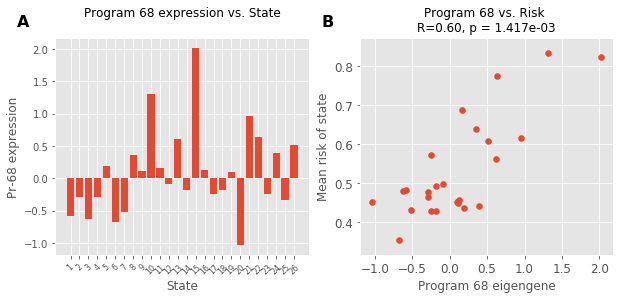

In [202]:
#Summary figure
fig, axs = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)

#bar plot
plt.sca(axs[0])
plt.bar(np.arange(len(mean_eigengene)),mean_eigengene)
plt.ylabel("Pr-68 expression",fontsize=12)
plt.xlabel("State",fontsize=12)
_=plt.xticks(np.arange(len(mean_eigengene)),
             labels=np.arange(1,len(mean_eigengene)+1),
            fontsize=8,rotation=45)
plt.title("Program 68 expression vs. State\n",fontsize=12)

#scatter plot
plt.sca(axs[1])
plt.scatter(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
r,p = stats.spearmanr(np.array(mean_eigengene)[np.array(guanrisk_mean)!=0],
            np.array(guanrisk_mean)[np.array(guanrisk_mean)!=0])
plt.ylabel("Mean risk of state",fontsize=12)
plt.xlabel("Program 68 eigengene",fontsize=12)
_=plt.yticks(fontsize=12)
_=plt.xticks(fontsize=12)
plt.title("Program 68 vs. Risk \nR={:.2f}, p = {:.3e}".format(r,p),fontsize=12)

#Add letters
import string
for n, ax in enumerate(axs):  
    ax.text(-0.15, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"Pr68_risk_plots.pdf"),bbox_inches='tight')


## Compare Pr-68 to cell cycle signature

In [ ]:
#Pick top 2 correlation signatures, plot km plots of top 2 + Pr-68

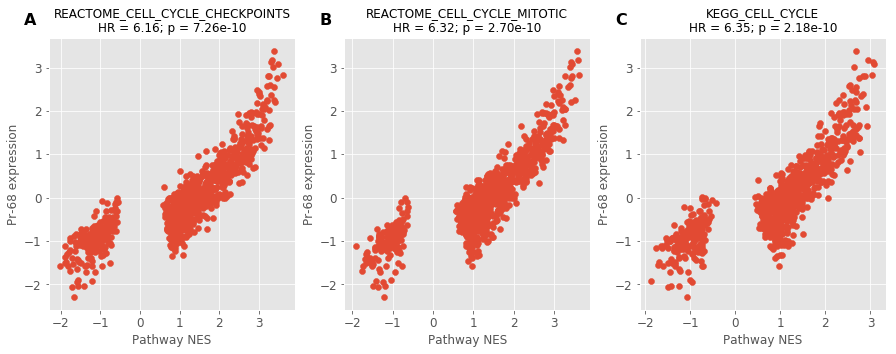

In [185]:
terms = ["REACTOME_CELL_CYCLE_CHECKPOINTS",
         "REACTOME_CELL_CYCLE_MITOTIC",
         "KEGG_CELL_CYCLE"]
         
#Instantiate figure
fig, axs = plt.subplots(1,len(terms))
fig.set_figheight(5)
fig.set_figwidth(15)

for i in range(len(terms)):
    term = terms[i]
    #Format pathway enrichments for survival analysis
    input_df = pd.DataFrame(pathways_mmrf.loc[term,:].T)
    input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

    #Perform Cox Hazards regression
    tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
    tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
    tmp_surv_df.columns = ["HR","p"]
    tmp_surv_df.index = [term]
    #print(tmp_surv_df)

    #Plot results
    plt.sca(axs[i])
    plt.scatter(pathways_mmrf.loc[term,:],eigengenes_pr.loc[program_id,pathways_mmrf.columns])

    title_str = term+'\nHR = '+'{:.2f}'.format(
        tmp_surv_df.loc[term,"HR"])+';'+' p = '+'{:.2e}'.format(
        tmp_surv_df.loc[term,"p"])

    plt.title(title_str,fontsize=12)
    plt.xlabel("Pathway NES",fontsize=12)
    plt.ylabel("Pr-68 expression",fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

#Add letters
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"Pr68_cell_cycle.pdf"),bbox_inches='tight')

In [171]:
print('HR = '+'{:.2f}'.format(tmp_surv_df.loc[term,"HR"])+';'+
' p = '+'{:.2e}'.format(tmp_surv_df.loc[term,"p"]))

HR = 6.16; p = 7.26e-10


## Perform Cox regression on programs

In [1037]:
# Cox proportional hazards regression of transcriptional programs
t1 = time.time()

cox_programs_output = miner.parallelMedianSurvivalAnalysis(pr_genes,expressionData,guanSurvivalDfMMRF,numCores=5)
cox_programs_output = cox_programs_output.iloc[np.argsort(np.array(cox_programs_output.index).astype(int))]
cox_programs_output.to_csv(os.path.join(resultsDirectory,'CoxProportionalHazardsPrograms.csv'))
cox_programs_output.sort_values(by="HR",ascending=False,inplace=True)

print("\nHigh-risk regulons:")
print(cox_programs_output.iloc[0:5,:])
print("\nLow-risk regulons")
print(cox_programs_output.iloc[-5:,:])

t2 = time.time()
print("Completed regulon risk analysis in {:.2f} minutes".format((t2-t1)/60.))


Completed 0 of 28 iterations
Completed 0 of 28 iterations
Completed 0 of 28 iterations
Completed 0 of 28 iterations
Completed 0 of 29 iterations

High-risk regulons:
          HR       p-value
68  8.811208  1.238043e-18
71  7.246735  4.269397e-13
69  6.862449  6.768991e-12
76  6.464156  1.018661e-10
54  6.404907  1.504607e-10

Low-risk regulons
           HR       p-value
36  -4.053011  5.056267e-05
26  -4.163220  3.137904e-05
110 -4.237206  2.263185e-05
61  -4.652298  3.282561e-06
104 -5.929361  3.041155e-09
Completed regulon risk analysis in 0.15 minutes


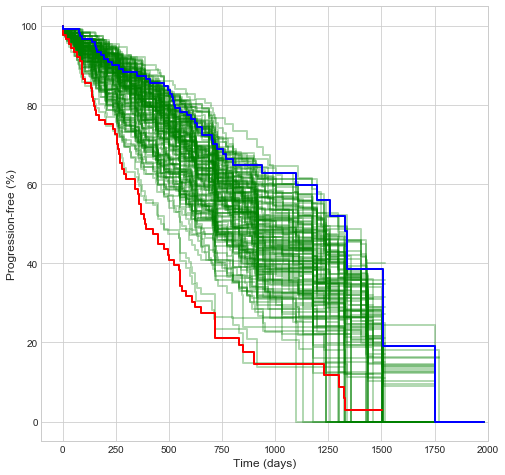

In [1038]:
# Kaplan-Meier plot of all programs (median expression)
srv = guanSurvivalDfMMRF.copy()
keys = list(pr_genes.keys())

plt.figure(figsize=(8,8))
plt.style.use('seaborn-whitegrid')
plt.xlim(-100,2000)
for key in keys:
    cluster = np.array(expressionData.loc[pr_genes[key],:])
    median_ = np.mean(cluster,axis=0)
    threshold = np.percentile(median_,85)
    median_[median_>=threshold] = 1
    median_[median_<threshold] = 0
    membership_df = pd.DataFrame(median_)
    membership_df.index = expressionData.columns
    membership_df.columns = [key]

    cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

    groups = [membership_df.index[np.where(membership_df[key]==1)[0]]]
    labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]
    miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
                 filename=None,lw=2,color="gray",alpha=0.3)  


key_min = cox_programs_output.index[0]
key_max = cox_programs_output.index[-1]

cluster = np.array(expressionData.loc[pr_genes[key_min],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_min]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_min]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="red",alpha=1)  

    
cluster = np.array(expressionData.loc[pr_genes[key_max],:])
median_ = np.mean(cluster,axis=0)
threshold = np.percentile(median_,85)
median_[median_>=threshold] = 1
median_[median_<threshold] = 0
membership_df = pd.DataFrame(median_)
membership_df.index = expressionData.columns
membership_df.columns = [key_max]

cox_hr, cox_p = miner.survivalMembershipAnalysisDirect(membership_df,guanSurvivalDfMMRF)

groups = [membership_df.index[np.where(membership_df[key_max]==1)[0]]]
labels = ["{0}: {1:.2f}".format(str(key), cox_hr)]

miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),
             filename=None,lw=2,color="blue",alpha=1) 

plt.savefig(os.path.join(resultsDirectory,"kmplots_programs.pdf"),bbox_inches="tight")

## Correlate program eigengenes to pathway enrichments

In [1040]:
pathway_results_dictionary = os.path.join(resultsDirectory,"pathway_correlations")
if not os.path.isdir(pathway_results_dictionary):
    os.mkdir(pathway_results_dictionary)
    
pathways_reference = pathways_mmrf
program_reference = eigengenes_pr
positive_only = False

for program_id in program_reference.index:

    pathway_rs = []
    pathway_ps = []
    for term in pathways_mmrf.index:
        if positive_only is True:
            tmp_patients = list(pathways_reference.columns[pathways_reference.loc[term,:]>0])
            r, p = stats.spearmanr(pathways_reference.loc[term,tmp_patients],
                           program_reference.loc[program_id,tmp_patients])
            pathway_rs.append(r)
            pathway_ps.append(p)

        elif positive_only is False:
            r, p = stats.spearmanr(pathways_reference.loc[term,:],
                               program_reference.loc[program_id,pathways_reference.columns])
            pathway_rs.append(r)
            pathway_ps.append(p)

    pathway_correlation = pd.DataFrame(np.vstack([pathway_rs,pathway_ps]).T)
    pathway_correlation.columns = ["R","p"]
    pathway_correlation.index = pathways_mmrf.index
    pathway_correlation.sort_values(by="R",ascending=False,inplace=True)


    #Define output directory to save optimized model
    output_dir = os.path.join(pathway_results_dictionary,str(program_id))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    #Write model to file
    tmp_output = pathway_correlation[pathway_correlation.p < 0.05]
    tmp_output.to_csv(os.path.join(output_dir,"pathway_correlations.csv"))
    
    if int(program_id)%10==0:
        print("completed iteration {:d}".format(int(program_id)+1))


completed iteration 1
completed iteration 11
completed iteration 21
completed iteration 31
completed iteration 41
completed iteration 51
completed iteration 61
completed iteration 71
completed iteration 81
completed iteration 91
completed iteration 101
completed iteration 111
completed iteration 121
completed iteration 131
completed iteration 141


## Probe specific programs for pathway correlation

In [1471]:
program_id = 61
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation_61 = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

program_id = 72
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation_72 = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

program_id = 73
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation_73 = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

miner.intersect(miner.intersect(pathway_correlation_72.index[0:20],
                pathway_correlation_73.index[0:20]),
                pathway_correlation_61.index[-20:])


['PID_MYC_ACTIV_PATHWAY', 'KEGG_PYRIMIDINE_METABOLISM']

In [ ]:
pathway_correlation_73

Text(0, 0.5, 'Mean(Pr-72, Pr-73)')

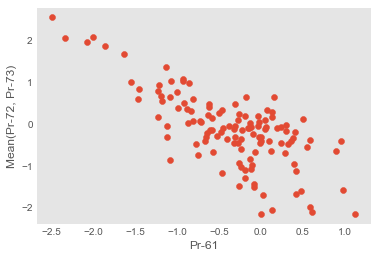

In [1479]:
plt.scatter(eigengenes_pr.loc[61,t414_patients],
           eigengenes_pr.loc[[72,73],t414_patients].mean(axis=0))
plt.grid(False)
plt.xlabel("Pr-61")
plt.ylabel("Mean(Pr-72, Pr-73)")

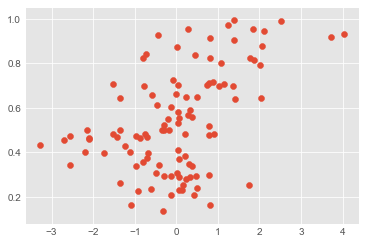

In [1484]:
t4p = t414_srv.index
plt.scatter(eigengenes_pr.loc[[72,73],t4p].mean(axis=0)-eigengenes_pr.loc[61,t4p],
            guanSurvivalDfMMRF.loc[t4p,"GuanScore"])

In [153]:
pathway_results_dictionary = os.path.join(os.path.split(os.getcwd())[0],"GSVA_results","pathway_correlations")
program_id = 68
output_dir = os.path.join(pathway_results_dictionary,str(program_id))
pathway_correlation = pd.read_csv(os.path.join(output_dir,"pathway_correlations.csv"),index_col=0,header=0)

pathway_correlation.head(25)

,R,p
PID_AURORA_B_PATHWAY,0.925296,0.000000e+00
REACTOME_MITOTIC_SPINDLE_CHECKPOINT,0.916381,0.000000e+00
REACTOME_POLO_LIKE_KINASE_MEDIATED_EVENTS,0.912907,0.000000e+00
REACTOME_CELL_CYCLE_CHECKPOINTS,0.903642,0.000000e+00
REACTOME_G1_S_SPECIFIC_TRANSCRIPTION,0.902946,0.000000e+00
REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX,0.901627,3.359646e-322
REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS,0.898173,5.757325e-316
REACTOME_CELL_CYCLE_MITOTIC,0.889158,1.117301e-300
REACTOME_DNA_STRAND_ELONGATION,0.884540,2.363981e-293
REACTOME_RESOLUTION_OF_SISTER_CHROMATID_COHESION,0.881086,4.481777e-288


                                 HR         p
KEGG_PYRIMIDINE_METABOLISM  3.67931  0.000234


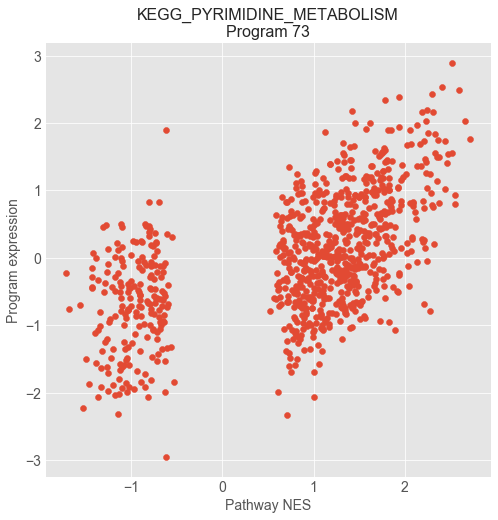

In [1488]:
term = "KEGG_PYRIMIDINE_METABOLISM"#"KEGG_CELL_CYCLE" #pathway_correlation.index[0]

plt.figure(figsize=(8,8))
plt.scatter(pathways_mmrf.loc[term,:],eigengenes_pr.loc[program_id,pathways_mmrf.columns])
plt.title(term+"\nProgram "+str(program_id),fontsize=16)
plt.xlabel("Pathway NES",fontsize=14)
plt.ylabel("Program expression",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#Format pathway enrichments for survival analysis
input_df = pd.DataFrame(pathways_mmrf.loc[term,:].T)
input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = [term]
print(tmp_surv_df)

## PPI network benchmarking

In [67]:
# Path to the scenic directory
scenic_path = os.path.join(os.path.expanduser('~'),'Desktop','scenic','results')

#Read clusters identified by differential expression + STRING analysis
ppi_clusters = pd.read_csv(os.path.join(scenic_path,'MINER','string_MCL_clusters.tsv'),sep='\t')
# Cluster 1
ppi_cluster_1 = list(ppi_clusters[ppi_clusters["cluster number"]==1]["protein name"])
ppi_cluster_1_ens = miner.gene_conversion(ppi_cluster_1,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)
# Cluster 2
ppi_cluster_2 = list(ppi_clusters[ppi_clusters["cluster number"]==2]["protein name"])
ppi_cluster_2_ens = miner.gene_conversion(ppi_cluster_2,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)
# Cluster 3
ppi_cluster_3 = list(ppi_clusters[ppi_clusters["cluster number"]==3]["protein name"])
ppi_cluster_3_ens = miner.gene_conversion(ppi_cluster_3,input_type="symbol",
                                          output_type="ensembl.gene",
                                         id_table=id_table,list_symbols=True)

#Format as dictionary
ppi_cluster_dict = {1:ppi_cluster_1_ens,
                   2:ppi_cluster_2_ens,
                   3:ppi_cluster_3_ens}

# Get eigengenes for all modules
eigengenes_ppi = miner.getEigengenes(ppi_cluster_dict,expressionData,regulon_dict=None,saveFolder=None)
eigenScale_ppi = np.percentile(expressionData,95)/np.percentile(eigengenes_ppi,95)
eigengenes_ppi = eigenScale_ppi*eigengenes_ppi
eigengenes_ppi.index = np.array(eigengenes_ppi.index).astype(int)

#Format pathway enrichments for survival analysis
input_df = pd.DataFrame(eigengenes_ppi.loc[1,:].T)
input_df = input_df.loc[guanSurvivalDfMMRF.index,:]

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(input_df,guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = ["PPI cluster 1"]
print(tmp_surv_df)

#Perform Cox Hazards regression
tmp_surv_results = miner.survivalMedianAnalysisDirect(pd.DataFrame(eigengenes_pr.loc[68,guanSurvivalDfMMRF.index].T),guanSurvivalDfMMRF.copy())
tmp_surv_df = pd.DataFrame([tmp_surv_results[list(tmp_surv_results.keys())[0]]])
tmp_surv_df.columns = ["HR","p"]
tmp_surv_df.index = ["Pr-68"]
print(tmp_surv_df)

                     HR             p
PPI cluster 1  8.163517  3.254072e-16
             HR             p
Pr-68  8.559045  1.138066e-17


In [73]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = ppi_cluster_dict
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_ppi = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_ppi = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedProgramsMatrix_ppi = miner.membershipToIncidence(overExpressedMembers_ppi,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_ppi = miner.membershipToIncidence(underExpressedMembers_ppi,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

done!
done!


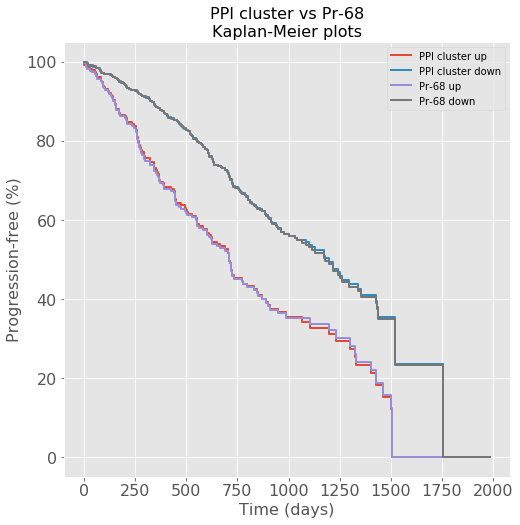

In [102]:
reload(miner)
#PPI cluster 1
ppi_1_up = overExpressedProgramsMatrix_ppi.columns[
    np.where(overExpressedProgramsMatrix_ppi.loc[1,:]==1)[0]
]
ppi_1_dn = miner.setdiff(overExpressedProgramsMatrix_ppi.columns,ppi_1_up)

#Program-68
pr68_up = overExpressedProgramsMatrix_pr.columns[
    np.where(overExpressedProgramsMatrix_pr.loc[68,:]==1)[0]
]
pr68_dn = miner.setdiff(overExpressedProgramsMatrix_pr.columns,pr68_up)

#KM plot
groups = [ppi_1_up,ppi_1_dn,pr68_up,pr68_dn]
labels = ["PPI cluster up","PPI cluster down",
         "Pr-68 up","Pr-68 down"]
plt.figure(figsize=(8,8))
gg = miner.kmplot(srv=guanSurvivalDfMMRF.copy(),groups=groups,
             labels=labels,legend=True,
             xlim_=(-100,1750),fs=16,lw=2,alpha=1,
             title="PPI cluster vs Pr-68\nKaplan-Meier plots",
             filename=os.path.join(resultsDirectory,"kmplots_ppi_pr68.pdf")) 

#plt.savefig(os.path.join(resultsDirectory,"kmplots_ppi_pr68.pdf"),bbox_inches="tight")

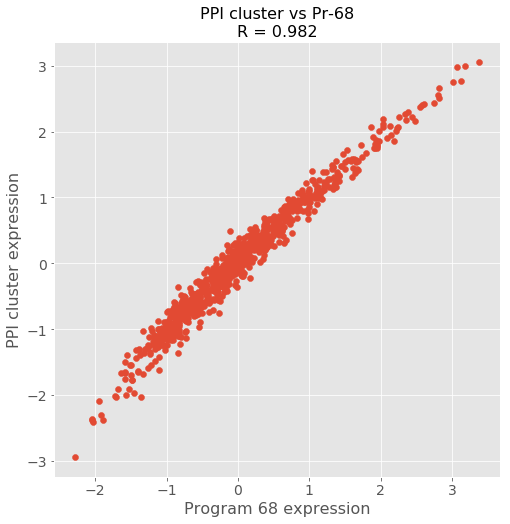

In [89]:
r,p = stats.spearmanr(eigengenes_pr.loc[68,:],eigengenes_ppi.loc[1,:])

plt.figure(figsize=(8,8))
plt.scatter(eigengenes_pr.loc[68,:],eigengenes_ppi.loc[1,:])
plt.title("PPI cluster vs Pr-68\nR = "+repr(round(r,3)),fontsize=16)
plt.xlabel("Program 68 expression",fontsize=16)
plt.ylabel("PPI cluster expression",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(os.path.join(resultsDirectory,"PPI_cluster_vs_Pr68.pdf"),bbox_inches="tight")

downloading 1u1afjc_6yJ-VpJWxSb2xI6LsEbC6RYTF
download complete


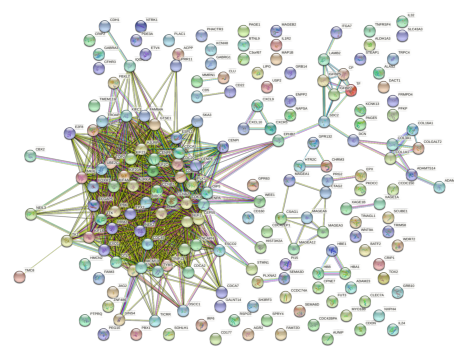

In [44]:
plt.figure(figsize=(8,8))
img1_file_id = '1u1afjc_6yJ-VpJWxSb2xI6LsEbC6RYTF'
destination = os.path.join(network_directory,"string_normal_image.png")
miner.download_file_from_google_drive(img1_file_id, destination)

img1 = plt.imread(destination)
plt.imshow(img1)
plt.grid(False)
plt.axis('off')
plt.savefig(os.path.join(resultsDirectory,"test.png"),dpi=400)

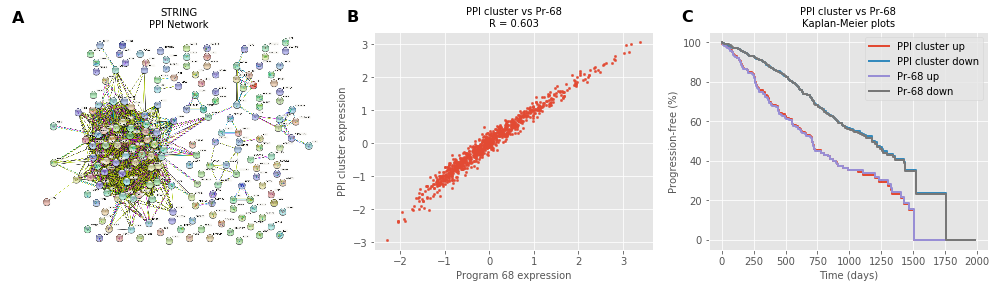

In [262]:
#Plot regulon maps side-by-side
# Create two subplots and unpack the output array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(17)

#Scenic regulon activity
plt.sca(ax1)
plt.imshow(img1)
plt.grid(False)
plt.axis('off')
plt.title("STRING\nPPI Network",fontsize=10)

#MINER regulon eigengenes
plt.sca(ax2)
plt.scatter(eigengenes_pr.loc[68,:],eigengenes_ppi.loc[1,:],s=5)
plt.title("PPI cluster vs Pr-68\nR = "+repr(round(r,3)),fontsize=10)
plt.xlabel("Program 68 expression",fontsize=10)
plt.ylabel("PPI cluster expression",fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#MINER regulon activity
plt.sca(ax3)
miner.kmplot(srv=guanSurvivalDfMMRF.copy(),groups=groups,
             labels=labels,legend=True,
             xlim_=(-100,1750),fs=10,lw=2,alpha=1,
             title="PPI cluster vs Pr-68\nKaplan-Meier plots",
             filename=None)


#Add letters
import string
axs = [ax1,ax2,ax3]
for n, ax in enumerate(axs):  
    ax.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

#Save figure
plt.savefig(os.path.join(resultsDirectory,"PPI_Pr68_comparison.png"),dpi=400,bbox_inches="tight")

## Evaluate combinatorial risk of pairwise programs

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

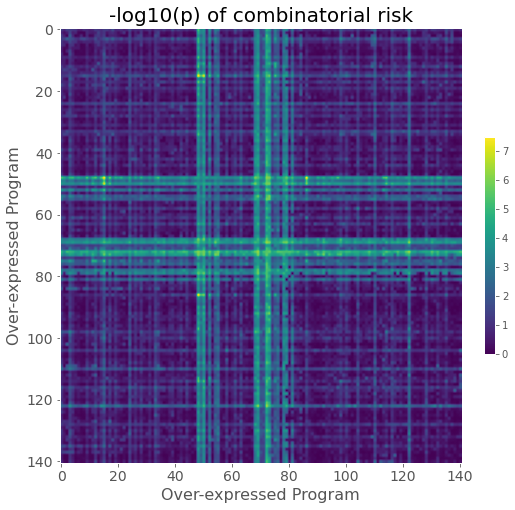

In [34]:
#Combination of over-expressed programs
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
over_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
over_combinatorial_pvalues.columns = reference_matrix.index
over_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
over_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
over_combinatorial_mean_risk.columns = reference_matrix.index
over_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
over_neglogp_combinatorial = -1*np.log10(over_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(over_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Over-expressed Program",fontsize=16)
plt.xlabel("Over-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

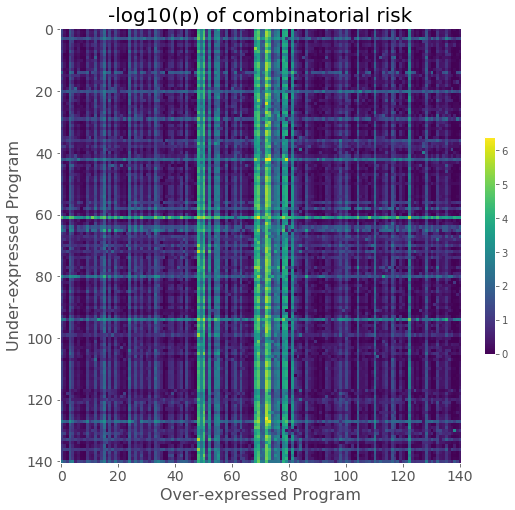

In [246]:
#Combination of over-expressed programs
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = underExpressedProgramsMatrix_pr.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
under_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
under_combinatorial_pvalues.columns = reference_matrix.index
under_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
under_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
under_combinatorial_mean_risk.columns = reference_matrix.index
under_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
under_neglogp_combinatorial = -1*np.log10(under_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(under_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Under-expressed Program",fontsize=16)
plt.xlabel("Over-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

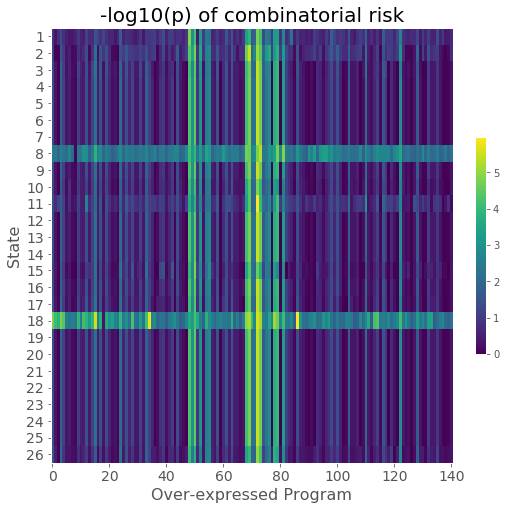

In [247]:
#Define Over-expressed programs versus states
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = overExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = states_df.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
states_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
states_combinatorial_pvalues.columns = reference_matrix.index
states_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
states_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
states_combinatorial_mean_risk.columns = reference_matrix.index
states_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
states_neglogp_combinatorial = -1*np.log10(states_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(states_df.shape[0]),
           labels=np.arange(1,states_df.shape[0]+1).astype(str),
           fontsize=14)
plt.ylabel("State",fontsize=16)
plt.xlabel("Over-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

Performing iteration 1 of 141
Performing iteration 11 of 141
Performing iteration 21 of 141
Performing iteration 31 of 141
Performing iteration 41 of 141
Performing iteration 51 of 141
Performing iteration 61 of 141
Performing iteration 71 of 141
Performing iteration 81 of 141
Performing iteration 91 of 141
Performing iteration 101 of 141
Performing iteration 111 of 141
Performing iteration 121 of 141
Performing iteration 131 of 141
Performing iteration 141 of 141


Text(0.5, 1.0, '-log10(p) of combinatorial risk')

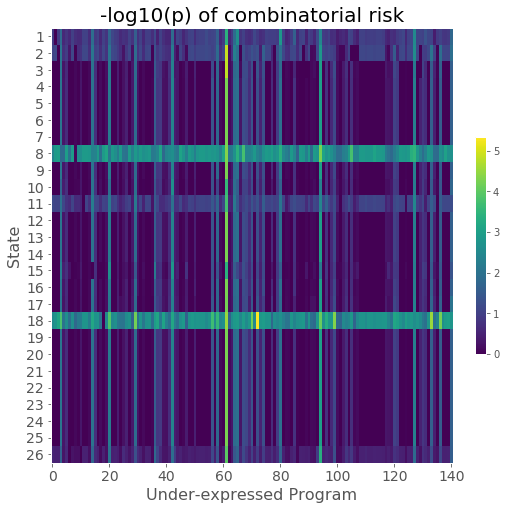

In [250]:
reload(miner)
#Define Over-expressed programs versus states
target = guanSurvivalDfMMRF.loc[:,"GuanScore"]
subset_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
reference_matrix = underExpressedProgramsMatrix_pr.loc[:,subset_patients]
covariate_matrix = states_df.loc[:,subset_patients]

pval_dfs = []
max_mean_dfs = []
for pr_ix in reference_matrix.index:
    if pr_ix%10==0:
        print("Performing iteration {:d} of {:d}".format(pr_ix+1,reference_matrix.shape[0]))
    tmp_pval = miner.combinatorial_risk(target,
                                  reference_matrix,
                                  covariate_matrix,
                                  primary_variable=pr_ix,
                                  min_group_size=5,
                                  sort=False)
    pval_dfs.append(tmp_pval.loc[:,"p-value"])
    max_mean_dfs.append(tmp_pval.loc[:,"highest_risk"])
    
#P-value combinatorial matrix
under_states_combinatorial_pvalues = pd.concat(pval_dfs,axis=1)
under_states_combinatorial_pvalues.columns = reference_matrix.index
under_states_combinatorial_pvalues.index = covariate_matrix.index

#Highest risk combination matrix
under_states_combinatorial_mean_risk = pd.concat(max_mean_dfs,axis=1)
under_states_combinatorial_mean_risk.columns = reference_matrix.index
under_states_combinatorial_mean_risk.index = covariate_matrix.index

#Transform data to -log10(p-values)
under_states_neglogp_combinatorial = -1*np.log10(under_states_combinatorial_pvalues)

#Plot the -log10(p-values) for the combinatorial risk
plt.figure(figsize=(8,8))
plt.imshow(under_states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=14)
plt.yticks(ticks=np.arange(states_df.shape[0]),
           labels=np.arange(1,states_df.shape[0]+1).astype(str),
           fontsize=14)
plt.ylabel("State",fontsize=16)
plt.xlabel("Under-expressed Program",fontsize=16)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=20)
#plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_pvalues.pdf"),bbox_inches="tight")

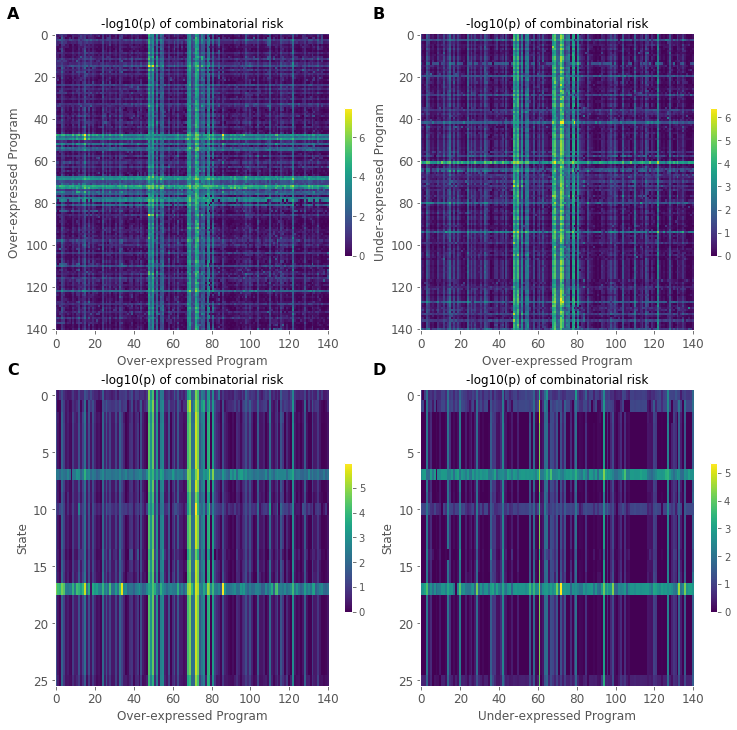

In [261]:
#Summary figure
fig, axs = plt.subplots(2,2)
fig.set_figheight(12)
fig.set_figwidth(12)

#programs over-over
plt.sca(axs[0,0])
plt.imshow(over_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Over-expressed Program",fontsize=12)
plt.xlabel("Over-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#programs under-over
plt.sca(axs[0,1])
plt.imshow(under_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Under-expressed Program",fontsize=12)
plt.xlabel("Over-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#programs over-states
plt.sca(axs[1,0])
plt.imshow(states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("State",fontsize=12)
plt.xlabel("Over-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#programs under-states
plt.sca(axs[1,1])
plt.imshow(under_states_neglogp_combinatorial,cmap="viridis",aspect="auto")
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("State",fontsize=12)
plt.xlabel("Under-expressed Program",fontsize=12)
plt.colorbar(shrink=0.5,fraction=0.05)
plt.title("-log10(p) of combinatorial risk",fontsize=12)

#Add letters
import string
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]
for n, ax in enumerate(axs):  
    ax.text(-0.175, 1.05, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=16, weight='bold')

plt.savefig(os.path.join(resultsDirectory,"Combinatorial_risk_figure.pdf"),bbox_inches="tight")


In [965]:
min_vals = np.amin(combinatorial_pvalues)
opt_pr1 = np.argmin(min_vals)
opt_pr2 = np.argmin(combinatorial_pvalues.loc[:,opt_pr1])
print("The minimum p-value of {:.3e} occurs for program {:d} split by program {:d}".format(min(min_vals)
                                                                                           ,opt_pr1,
                                                                                           opt_pr2))

The minimum p-value of 1.920e-08 occurs for program 122 split by program 61


In [966]:
max_vals = np.amax(combinatorial_mean_risk)
opt_pr1 = np.argmax(max_vals)
opt_pr2 = np.argmax(combinatorial_mean_risk.loc[:,opt_pr1])
print("The maximum mean risk occurs for program {:d} split by program {:d}".format(opt_pr1,opt_pr2))


The maximum mean risk occurs for program 73 split by program 30


In [975]:
#Determine primary variable type
primary_variable = 122
covariate_variable = 61

indicator = len(set(reference_matrix.loc[primary_variable,:]))
if indicator == 2:
    primary_type = "binary"
elif indicator >2:
    primary_type = "categorical"

#Get target variable names outside of loop to save time
target_index = target.index

#Instantiate output lists
kw_stat_list = []
kw_p_list = []
index_list = []
labels = []

phenotypes = []
#Split population according to primary variable
if primary_type == "binary":
    phenotypes.append(miner.getMutations(primary_variable,reference_matrix))
    phenotypes.append(miner.setdiff(reference_matrix.columns,phenotype1))

if primary_type == "categorical":
    for cat in list(set(reference_matrix.loc[primary_variable,:])):
        phenotypes.append(reference_matrix.columns[
            np.where(reference_matrix.loc[primary_variable,:]==cat)[0]])

if primary_type == "continuous":
    phenotypes.append(reference_matrix.columns)

#Split population into subtypes based upon primary and categorical variables
for covariate in [covariate_variable]:
    interaction_subtypes = []
    cats = list(set(covariate_matrix.loc[covariate,:]))
    for cat in cats:
        subtype = covariate_matrix.columns[
            np.where(covariate_matrix.loc[covariate,:]==cat)[0]]
        for p in range(len(phenotypes)):
            phenotype = phenotypes[p]
            labels.append((" ").join([str(len(phenotypes)-1-p),str(cat)]))
            cat_subtype = miner.intersect(phenotype,subtype)
            interaction_subtypes.append(cat_subtype)
            
            
#kruskal-wallis of subtypes
kw_subtypes = []
lenkw = 0
for group in interaction_subtypes:
    kw_subtype = miner.intersect(target_index,group)
    if len(kw_subtype) >= min_group_size:
        kw_subtypes.append(target[kw_subtype])
        lenkw+=1
if lenkw >= 2:
    kw_stat, kw_p = stats.kruskal(*kw_subtypes)
    print(kw_p)
    
means = [np.mean(i) for i in kw_subtypes if len(miner.intersect(i.index,target_index))>=5]
max_mean = max(means)
print(max_mean)

print(labels)

1.9204566076614914e-08
0.8588011137711781
['1 0.0', '0 0.0', '1 1.0', '0 1.0']


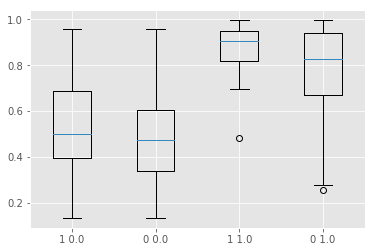

In [976]:
risk_subtypes = []
for subtype in interaction_subtypes:
    subtype = miner.intersect(subtype,guanSurvivalDfMMRF.index)
    risk_subtypes.append(guanSurvivalDfMMRF.loc[subtype,"GuanScore"])

_=plt.boxplot(risk_subtypes,labels=labels) 

## Compare program status to various features

In [ ]:
#Available tests:
#chisquare_binary_df - test and reference dfs are both binary
#wilcox_binary_df - test df is binary, reference df is continuous
#wilcox_df - continuous df with 2 phenotypes to compare
#decision_tree_predictor - test and reference features are both continuous

## Predict state using continuous programs

In [61]:
t414_patients = miner.getMutations("RNASeq_WHSC1_Call",translocations)
t414_srv = miner.subset_survival(t414_patients,guanSurvivalDfMMRF)
t414_hr = list(t414_srv.index[0:int(round(0.35*t414_srv.shape[0]))])
subset_patients = t414_srv.index

target_df = pd.DataFrame(np.zeros((len(subset_patients),1)))
target_df.index = subset_patients
target_df.columns = ["HR_t414"]
target_df.loc[t414_hr,"HR_t414"] = 1

#subset_patients = expressionData.columns

Chi-square statistic: 0.68, p-value: 4.097e-01
col_0   0   1
row_0        
0      18  12
1       3   4


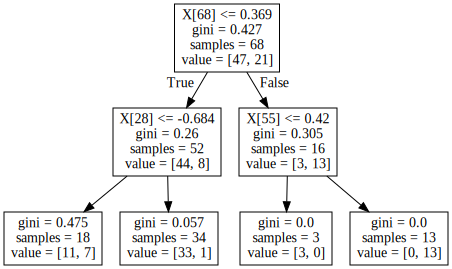

In [62]:
#Identify optimal combination of continuous features
clf, X_train, X_test, y_train, y_test, y_train_samples, y_test_samples = miner.decision_tree_predictor(
    ref_df=eigengenes_pr.loc[:,subset_patients],
    target=target_df,
    test_proportion=0.35,
    rs=12,
    depth=2,
    criterion="gini")

#Predict target class
tmp_train_predictions = clf.predict(X_train)
tmp_test_predictions = clf.predict(X_test)
 
#Print test performance
if len(set(tmp_test_predictions))>1:
    if len(set(y_test))>1:
        chi2, p, obs = miner.chi_square(tmp_test_predictions,y_test,table=True)
        print('Chi-square statistic: {:.2f}, p-value: {:.3e}'.format(chi2,p))
        print(obs)
        
#Visualize tree
miner.visualize_decision_tree(clf,filename=None)

## Predict state using discrete program activity

In [1135]:
reload(miner)
bin_df = common_mutations
ref_df = overExpressedProgramsMatrix_pr
pr_key = 68

chisq_results = miner.chisquare_binary_df(bin_df,ref_df,pr_key)
chisq_results.head()

,statistic,p-value
TP53,37.185968,1.073837e-09
ZNF462,12.174404,4.844978e-04
ZNF208,11.982900,5.369096e-04
CMYA5,11.915528,5.566795e-04
TTN,9.541820,2.008425e-03


In [ ]:
bin_df = common_mutations
ref_df = overExpressedProgramsMatrix_pr
pr_key = 68
chisq_results = chisquare_binary_df(bin_df,ref_df,pr_key)

In [1123]:
chisq_results = chisquare_binary_df(bin_df=states_df,ref_df=overExpressedProgramsMatrix_pr,pr_key=68)
chisq_results.head()

,statistic,p-value
15,45.987691,1.189983e-11
21,44.896723,2.077052e-11
1,20.219705,6.903811e-06
13,12.190397,4.803617e-04
4,10.043275,1.529051e-03


In [1124]:
chisq_results = chisquare_binary_df(bin_df=translocations,ref_df=overExpressedProgramsMatrix_pr,pr_key=68)
chisq_results.head()

,statistic,p-value
RNASeq_MYC_Call,7.989413,0.004705
RNASeq_MAF_Call,5.266072,0.021745
RNASeq_MAFA_Call,3.279238,0.070162
RNASeq_CCND3_Call,2.336438,0.126378
RNASeq_MAFB_Call,1.615868,0.203669


In [1133]:
reload(miner)

wilcox_results = miner.wilcox_binary_df(bin_df=translocations,
                                  cont_df=eigengenes_pr,
                                  pr_key=73)
wilcox_results.head()

,statistic,p-value
RNASeq_MAF_Call,6.680626,2.379235e-11
RNASeq_MYC_Call,5.531441,3.176105e-08
RNASeq_MAFA_Call,4.416430,1.003444e-05
RNASeq_MAFB_Call,3.780609,1.564449e-04
RNASeq_CCND2_Call,-0.550861,5.817287e-01


In [1127]:
wilcox_results = wilcox_binary_df(translocations,cont_df,pr_key=68)
wilcox_results

,statistic,p-value
RNASeq_MAF_Call,3.862306,0.000112
RNASeq_MYC_Call,3.753700,0.000174
RNASeq_MAFA_Call,2.300025,0.021447
RNASeq_CCND1_Call,1.614870,0.106339
RNASeq_CCND3_Call,1.540876,0.123347
RNASeq_CCND2_Call,1.454656,0.145765
RNASeq_WHSC1_Call,0.901528,0.367308
RNASeq_MAFB_Call,0.872955,0.382688
RNASeq_FGFR3_Call,0.354563,0.722917


In [1126]:
wilcox_results = wilcox_binary_df(states_df,cont_df,pr_key=1)
wilcox_results

,statistic,p-value
1,14.612533,2.336649e-48
2,8.773725,1.728516e-18
3,4.428992,9.467444e-06
16,4.299013,1.715607e-05
15,2.753081,5.903731e-03
10,2.581418,9.839549e-03
22,1.753247,7.955962e-02
9,1.045213,2.959245e-01
26,-0.003072,9.975486e-01
11,-0.251214,8.016489e-01


In [ ]:
program_ix = 68
mean_eigengene = []
mean_activity = []
wilcoxon_eigengene = []
wilcoxon_activity = []
guanrisk_mean = []


for s in range(len(states)):
    phenotype1 = states[s]
    phenotype2 = miner.setdiff(np.hstack(states),phenotype1)
    tmp_activity = np.mean(dfr_pr.loc[program_ix,phenotype1])
    tmp_eigengene = np.mean(eigengenes_pr.loc[program_ix,phenotype1])
    tmp_wilcox_activity = stats.ranksums(dfr_pr.loc[program_ix,phenotype1],dfr_pr.loc[program_ix,phenotype2])
    tmp_wilcox_eigengene = stats.ranksums(eigengenes_pr.loc[program_ix,phenotype1],eigengenes_pr.loc[program_ix,phenotype2])
    tmp_pats = miner.intersect(phenotype1,guanSurvivalDfMMRF.index)
    tmp_guan = 0
    if len(tmp_pats) >= 3:
        tmp_guan = guanSurvivalDfMMRF.loc[tmp_pats,"GuanScore"].mean()
         
    # Append to lists
    mean_eigengene.append(tmp_eigengene)
    mean_activity.append(tmp_activity)
    wilcoxon_eigengene.append(tmp_wilcox_eigengene)
    wilcoxon_activity.append(tmp_wilcox_activity)
    guanrisk_mean.append(tmp_guan)
    

## Investigate specific states

In [39]:
state_ix = 14

mean_eigengene = []
mean_activity = []
wilcoxon_eigengene = []
wilcoxon_activity = []

for program_ix in dfr_pr.index:

    phenotype1 = states[state_ix]
    phenotype2 = miner.setdiff(np.hstack(states),phenotype1)
    tmp_activity = np.mean(dfr_pr.loc[program_ix,phenotype1])
    tmp_eigengene = np.mean(eigengenes_pr.loc[program_ix,phenotype1])
    tmp_wilcox_activity = stats.ranksums(dfr_pr.loc[program_ix,phenotype1],dfr_pr.loc[program_ix,phenotype2])
    tmp_wilcox_eigengene = stats.ranksums(eigengenes_pr.loc[program_ix,phenotype1],eigengenes_pr.loc[program_ix,phenotype2])
    # Append to lists
    mean_eigengene.append(tmp_eigengene)
    mean_activity.append(tmp_activity)
    wilcoxon_eigengene.append(tmp_wilcox_eigengene)
    wilcoxon_activity.append(tmp_wilcox_activity)


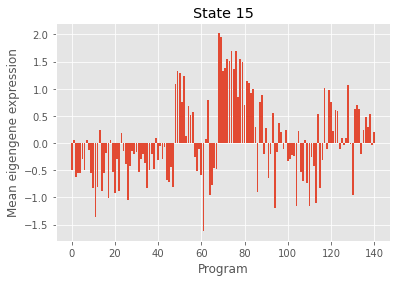

In [40]:
plt.bar(np.arange(len(mean_eigengene)),mean_eigengene)
plt.ylabel("Mean eigengene expression")
plt.xlabel("Program")
plt.title("State "+str(state_ix+1))
plt.show()